In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import os
import random
import cv2

import tensorflow as tf
from PIL import Image
import yaml
from collections import defaultdict

In [ ]:
import albumentations as A
import shutil
from tqdm import tqdm

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
dir = "drive/My Drive/UAO/7° Semestre/IA Embebidos/proyecto_3/Trash"

In [ ]:
with open(os.path.join(dir, "data.yaml"), 'r') as f:
  data_yaml = yaml.safe_load(f)
  class_names = data_yaml['names']
  num_classes = len(class_names)

In [ ]:
print(class_names)
print(num_classes)

['Bateria', 'BotellaPlastico', 'BotellaVidrio', 'HojaPapel', 'TapaPlastico', 'TazaPapel']
6


In [ ]:
def show_image_with_boxes(img_path, label_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  h, w = img.shape[:2]

  fig, ax = plt.subplots(1)
  ax.imshow(img)

  with open(label_path, 'r') as f:
    for line in f.readlines():
      cls_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())
      x_center *= w
      y_center *= h
      box_w *= w
      box_h *= h
      x1 = x_center - box_w / 2
      y1 = y_center - box_h / 2
      rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                                edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      ax.text(x1, y1 - 10, class_names[int(cls_id)],
              color='white', backgroundcolor='red', fontsize=8)
  plt.axis('off')
  plt.show()

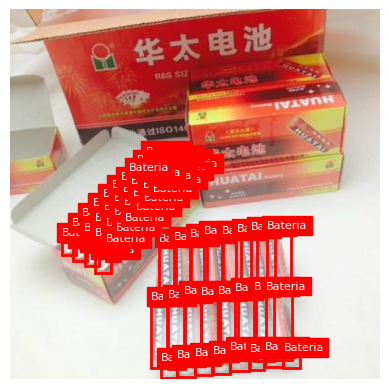

In [ ]:
subsets = ['train']

subset = subsets[0]
images_dir = os.path.join(dir, subset, 'images')
labels_dir = os.path.join(dir, subset, 'labels')

random_image = random.choice(os.listdir(images_dir))
img_path = os.path.join(images_dir, random_image)
label_path = os.path.join(labels_dir, random_image.replace('.jpg', '.txt').replace('.png', '.txt'))

show_image_with_boxes(img_path, label_path)

In [ ]:
def count_boxes_per_class(base_path, sets):
  stats = {}

  for s in sets:
    labels_dir = os.path.join(base_path, s, 'labels')
    class_counts = defaultdict(int)

    for label_file in os.listdir(labels_dir):
      with open(os.path.join(labels_dir, label_file), 'r') as f:
        for line in f:
          cls_id = int(float(line.strip().split()[0]))
          class_counts[cls_id] += 1

    stats[s] = {class_names[k]: v for k, v in class_counts.items()}
  return stats

In [ ]:
box_stats = count_boxes_per_class(dir, subsets)

for split, counts in box_stats.items():
  print(f"\n{split.upper()}")
  for cls, count in counts.items():
    print(f"  {cls}: {count} boxes")


TRAIN
  BotellaVidrio: 5232 boxes
  HojaPapel: 2283 boxes
  BotellaPlastico: 2930 boxes
  TapaPlastico: 3296 boxes
  TazaPapel: 3090 boxes
  Bateria: 2426 boxes


## Balancear las clases

In [ ]:
minority_class_ids = [0, 1, 2, 3, 4, 5]
target_boxes = 5232

In [ ]:
transform = A.Compose([
  A.HorizontalFlip(p=0.5),
  A.RandomBrightnessContrast(p=0.5),
  A.Rotate(limit=15, p=0.5),
  A.MotionBlur(p=0.3),
  A.ColorJitter(p=0.4),
  ],
  bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)

In [ ]:
box_counter = {i: 0 for i in range(len(class_names))}

In [ ]:
for file in os.listdir(labels_dir):
  with open(os.path.join(labels_dir, file), 'r') as f:
    for line in f:
      class_id = int(line.split()[0])
      box_counter[class_id] += 1

In [ ]:
print("Boxes actuales por clase:")
for i, count in box_counter.items():
  print(f"{class_names[i]}: {count}")

Boxes actuales por clase:
Bateria: 2426
BotellaPlastico: 2930
BotellaVidrio: 5232
HojaPapel: 2283
TapaPlastico: 3296
TazaPapel: 3090


In [ ]:
for label_file in os.listdir(labels_dir):
  with open(os.path.join(labels_dir, label_file), 'r') as f:
    for line in f:
      try:
        class_id = int(float(line.split()[0]))
      except ValueError as e:
        print(f"Error en archivo: {label_file}, línea: {line.strip()}")

In [ ]:
for class_id in minority_class_ids:
  current_boxes = box_counter[class_id]
  needed_boxes = target_boxes - current_boxes
  if needed_boxes <= 0:
    continue

  print(f"\n🚀 Generando {needed_boxes} boxes para clase '{class_names[class_id]}'...")

  # Recolectar imágenes con esa clase
  image_label_pairs = []
  for label_file in os.listdir(labels_dir):
    label_path = os.path.join(labels_dir, label_file)
    with open(label_path, 'r') as f:
      lines = f.readlines()
    lines_for_class = [line for line in lines if int(float(line.split()[0])) == class_id]
    if lines_for_class:
      image_path = os.path.join(images_dir, label_file.replace('.txt', '.jpg'))
      if not os.path.exists(image_path):
        image_path = image_path.replace('.jpg', '.png')  # Por si acaso
      image_label_pairs.append((image_path, label_path, lines_for_class))

  # Aumentar hasta llegar a la meta
  generated = 0
  idx = 0
  while generated < needed_boxes:
    img_path, lbl_path, lines_for_class = random.choice(image_label_pairs)
    image = cv2.imread(img_path)
    height, width = image.shape[:2]

    # Preparar cajas y etiquetas
    bboxes = []
    labels = []
    for line in lines_for_class:
      parts = line.strip().split()
      cid, x, y, w, h = int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
      bboxes.append([x, y, w, h])
      labels.append(cid)

    # Aplicar aumento
    transformed = transform(image=image, bboxes=bboxes, class_labels=labels)

    # Guardar imagen aumentada
    new_img = transformed["image"]
    new_bboxes = transformed["bboxes"]
    new_labels = transformed["class_labels"]

    if not new_bboxes:
      continue  # Skip si el aumento destruyó las cajas

    new_filename = f"aug_{class_names[class_id]}_{idx}.jpg"
    new_labelname = new_filename.replace(".jpg", ".txt")
    cv2.imwrite(os.path.join(images_dir, new_filename), new_img)

    with open(os.path.join(labels_dir, new_labelname), "w") as f:
      for lbl, (x, y, w, h) in zip(new_labels, new_bboxes):
        f.write(f"{lbl} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

    generated += len(new_bboxes)
    idx += 1

  print(f"✅ Generadas {generated} cajas nuevas para clase '{class_names[class_id]}'")



🚀 Generando 2806 boxes para clase 'Bateria'...
✅ Generadas 2810 cajas nuevas para clase 'Bateria'

🚀 Generando 2302 boxes para clase 'BotellaPlastico'...
✅ Generadas 2307 cajas nuevas para clase 'BotellaPlastico'

🚀 Generando 2949 boxes para clase 'HojaPapel'...
✅ Generadas 2949 cajas nuevas para clase 'HojaPapel'

🚀 Generando 1936 boxes para clase 'TapaPlastico'...
✅ Generadas 1936 cajas nuevas para clase 'TapaPlastico'

🚀 Generando 2142 boxes para clase 'TazaPapel'...
✅ Generadas 2145 cajas nuevas para clase 'TazaPapel'


In [ ]:
subsets = ['train']

In [ ]:
for subset in subsets:
  labels_dir = os.path.join(dir, subset, 'labels')
  box_count = defaultdict(int)

  for label_file in os.listdir(labels_dir):
    with open(os.path.join(labels_dir, label_file), 'r') as f:
      for line in f:
        try:
          class_id = int(float(line.strip().split()[0]))
          box_count[class_id] += 1
        except:
          continue

  print(f"\n{subset.upper()}")
  for class_id, count in sorted(box_count.items()):
    print(f"  {class_names[class_id]}: {count} boxes")


TRAIN
  Bateria: 5236 boxes
  BotellaPlastico: 5237 boxes
  BotellaVidrio: 5232 boxes
  HojaPapel: 5232 boxes
  TapaPlastico: 5232 boxes
  TazaPapel: 5235 boxes


## Balancear Train, Test y Valid

### Centralizar imágenes en images_all y labels_all

In [ ]:
subsets = ['train']

In [ ]:
images_all_dir = os.path.join(dir, "images_all")
labels_all_dir = os.path.join(dir, "labels_all")
os.makedirs(images_all_dir, exist_ok=True)
os.makedirs(labels_all_dir, exist_ok=True)

In [ ]:
# Procesar cada subset
for subset in subsets:
  images_dir = os.path.join(dir, subset, "images")
  labels_dir = os.path.join(dir, subset, "labels")

  for img_file in os.listdir(images_dir):
    src_img = os.path.join(images_dir, img_file)
    dst_img = os.path.join(images_all_dir, f"{subset}_{img_file}")
    shutil.copy(src_img, dst_img)

  for lbl_file in os.listdir(labels_dir):
    src_lbl = os.path.join(labels_dir, lbl_file)
    dst_lbl = os.path.join(labels_all_dir, f"{subset}_{lbl_file}")
    shutil.copy(src_lbl, dst_lbl)

print(f"Dataset combinado {subset} en 'images_all/' y 'labels_all/'")

Dataset combinado train en 'images_all/' y 'labels_all/'


### Balancear carpetas desde images_all y labels_all

In [ ]:
subsets = ['train', 'valid', 'test']

In [ ]:
def get_images_by_class(labels_dir):
  images_by_class = defaultdict(list)

  for label_file in os.listdir(labels_dir):
    if not label_file.endswith('.txt'):
      continue
    path = os.path.join(labels_dir, label_file)
    with open(path, 'r') as f:
      lines = f.readlines()
    for line in lines:
      parts = line.strip().split()
      if len(parts) == 0:
        continue  # línea vacía
      try:
        class_id = int(float(parts[0]))
      except ValueError:
        continue  # línea inválida
      img_name = label_file.replace('.txt', '.jpg')  # o .png si es tu caso
      if img_name not in images_by_class[class_id]:
        images_by_class[class_id].append(img_name)
      break  # solo la primera clase por imagen
  return images_by_class

In [ ]:
def redistribute_images(base_dir, class_names, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):
  assert abs(train_ratio + valid_ratio + test_ratio - 1.0) < 1e-6, "Ratios deben sumar 1"

  # Reset folders
  for split in ['train', 'valid', 'test']:
    for kind in ['images', 'labels']:
      split_path = os.path.join(base_dir, split, kind)
      if not os.path.exists(split_path):
        os.makedirs(split_path)
      else:
        for f in os.listdir(split_path):
          os.remove(os.path.join(split_path, f))

  # Obtener imágenes por clase
  labels_dir = os.path.join(base_dir, 'labels_all')  # <- Carpeta donde están todas las etiquetas
  images_dir = os.path.join(base_dir, 'images_all')  # <- Carpeta donde están todas las imágenes
  images_by_class = get_images_by_class(labels_dir)

  seen = set()  # Evitar duplicados

  for class_id, image_list in images_by_class.items():
    random.shuffle(image_list)
    total = len(image_list)
    train_end = int(train_ratio * total)
    valid_end = train_end + int(valid_ratio * total)

    splits = {
      'train': image_list[:train_end],
      'valid': image_list[train_end:valid_end],
      'test': image_list[valid_end:]
    }

    for split, imgs in splits.items():
      for img_name in imgs:
        if img_name in seen:
          continue  # Evitar duplicados
        seen.add(img_name)

        # Copiar imagen
        src_img = os.path.join(images_dir, img_name)
        dst_img = os.path.join(base_dir, split, 'images', img_name)
        shutil.copy(src_img, dst_img)

        # Copiar etiqueta
        label_name = img_name.replace('.jpg', '.txt')
        src_lbl = os.path.join(labels_dir, label_name)
        dst_lbl = os.path.join(base_dir, split, 'labels', label_name)
        if os.path.exists(src_lbl):
          shutil.copy(src_lbl, dst_lbl)

In [ ]:
redistribute_images(
  base_dir= dir,
  class_names= class_names,
  train_ratio= 0.7,
  valid_ratio= 0.2,
  test_ratio= 0.1
)

In [ ]:
box_stats = count_boxes_per_class(dir, subsets)

for split, counts in box_stats.items():
  print(f"\n{split.upper()}")
  for cls, count in counts.items():
    print(f"  {cls}: {count} boxes")


TRAIN
  BotellaVidrio: 3755 boxes
  TapaPlastico: 3737 boxes
  BotellaPlastico: 3758 boxes
  HojaPapel: 3746 boxes
  TazaPapel: 3704 boxes
  Bateria: 3811 boxes

VALID
  BotellaVidrio: 1001 boxes
  TapaPlastico: 1047 boxes
  BotellaPlastico: 1007 boxes
  HojaPapel: 1016 boxes
  TazaPapel: 944 boxes
  Bateria: 997 boxes

TEST
  BotellaVidrio: 476 boxes
  TapaPlastico: 448 boxes
  HojaPapel: 470 boxes
  BotellaPlastico: 472 boxes
  TazaPapel: 587 boxes
  Bateria: 428 boxes
